   data_id  iso event_id_cnty  event_id_no_cnty event_date  year  \
0  9197626  729      SUD16632             16632  31-Dec-21  2021   
1  8706358  729      SUD16188             16188  30-Dec-21  2021   
2  8706372  729      SUD16191             16191  30-Dec-21  2021   
3  8706400  729      SUD16205             16205  30-Dec-21  2021   
4  8706414  729      SUD16206             16206  30-Dec-21  2021   

   time_precision                  event_type                sub_event_type  \
0               1  Violence against civilians                        Attack   
1               1      Strategic developments  Looting/property destruction   
2               1  Violence against civilians                        Attack   
3               1  Violence against civilians                        Attack   
4               1  Violence against civilians                        Attack   

                             actor1  ...    location  latitude longitude  \
0   Darfur Communal Militia (Sudan)  ...

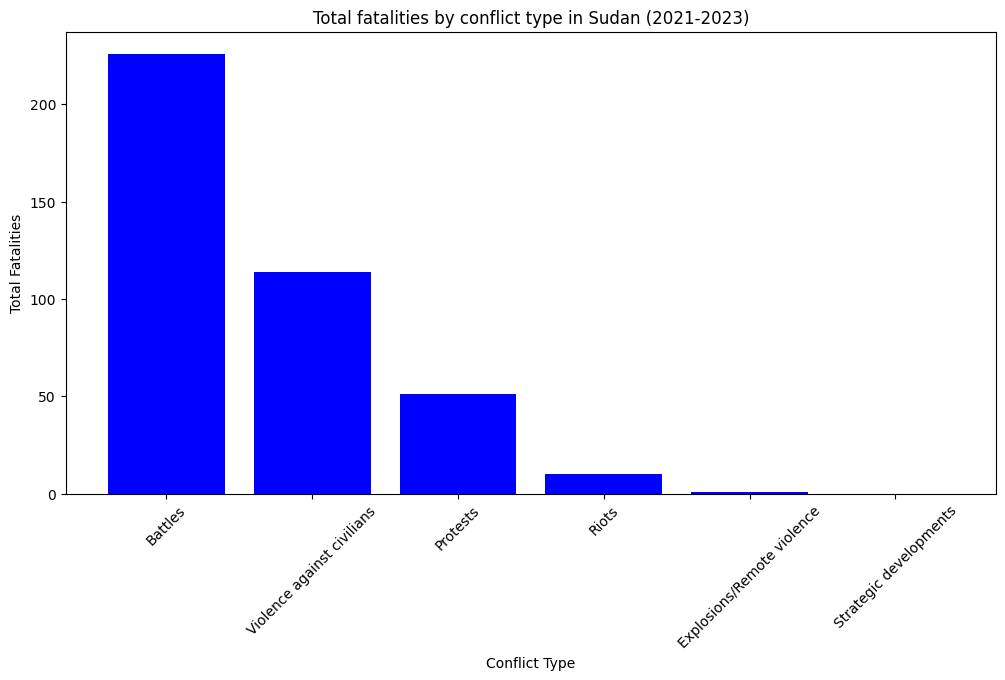

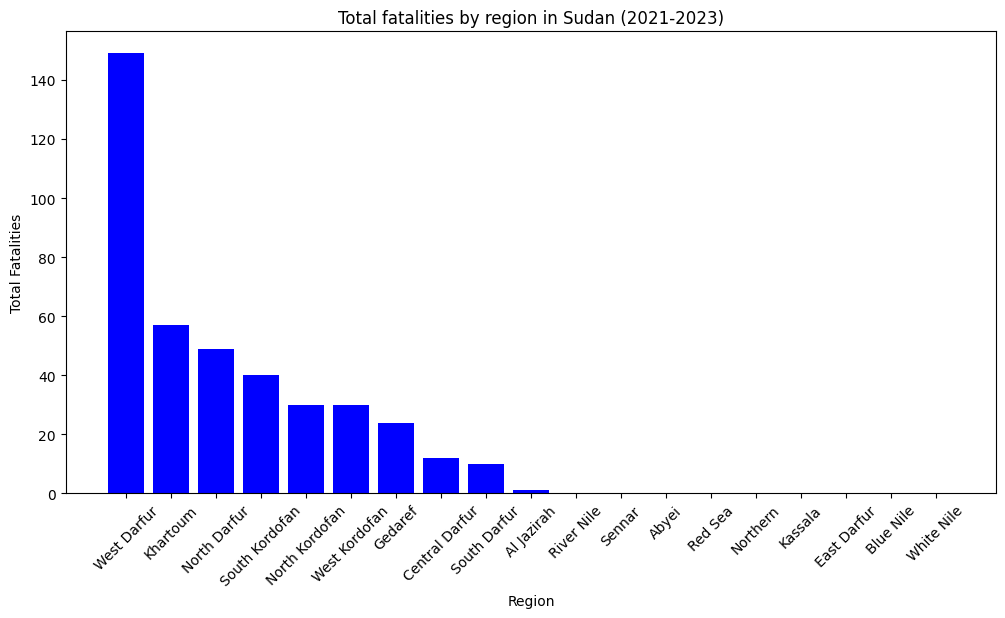

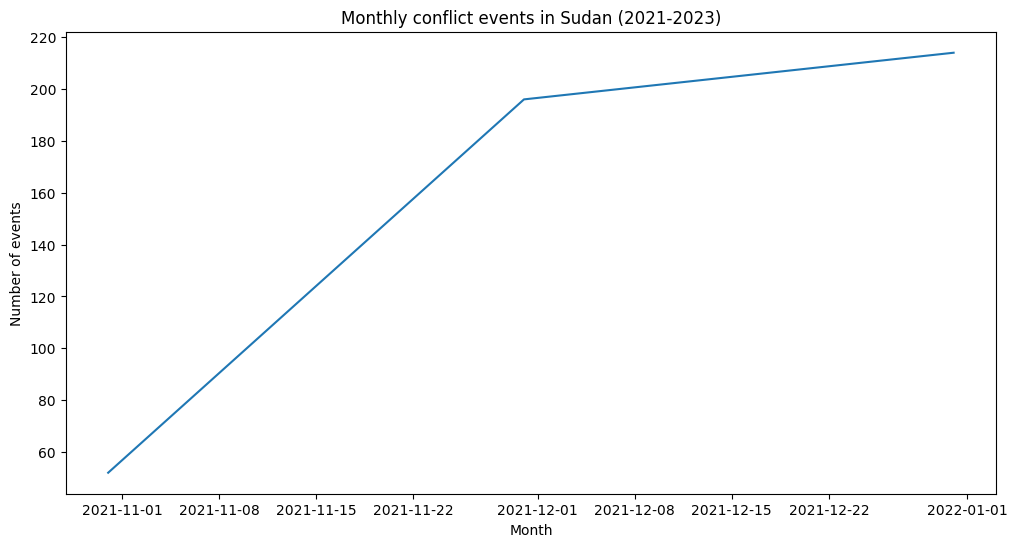

/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8172043010752689


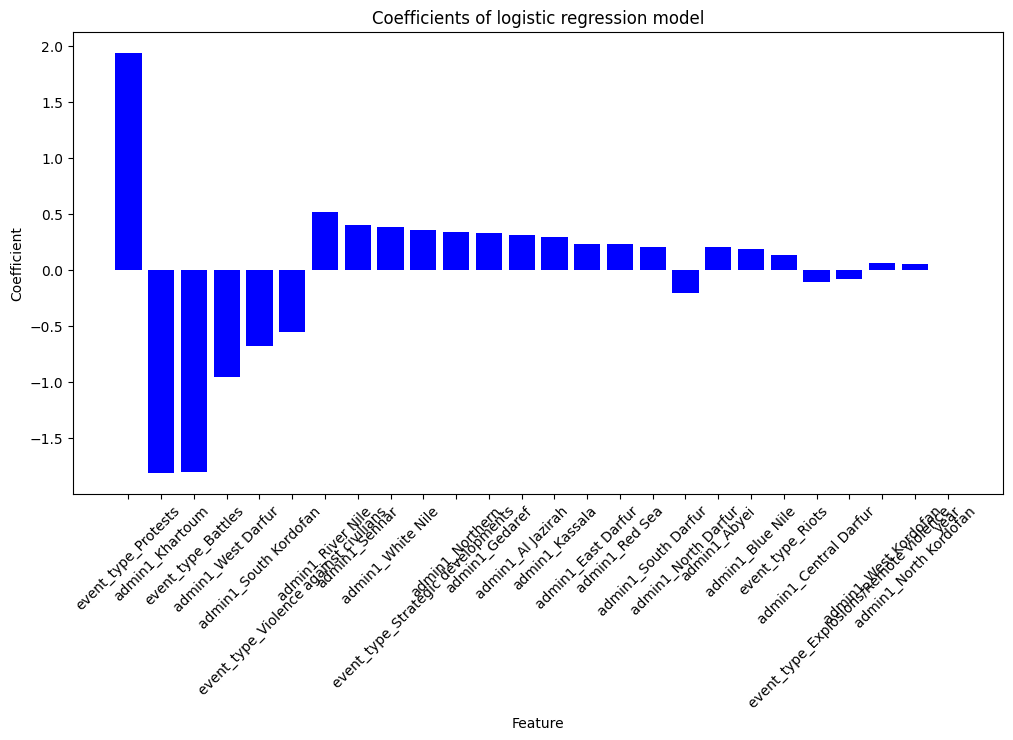

Accuracy: 0.8172043010752689


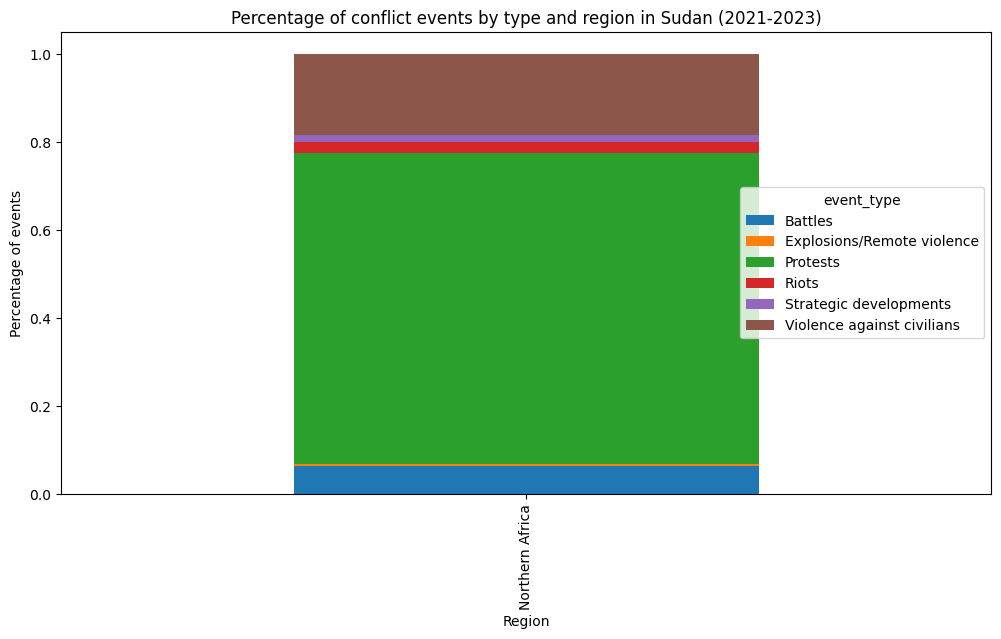

In [4]:
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Import the ACLED dataset for Sudan from 2021 to 2023
acled_data = pd.read_csv('SudanData.csv')

# View the first five rows of the data frame
print(acled_data.head())



# Rename columns to make them more readable
acled_data = acled_data.rename(columns={'event_date': 'date_time', 'source': 'source_reported'})
print(acled_data.columns)

# Convert the date_time column to a datetime format
acled_data['date_time'] = pd.to_datetime(acled_data['date_time'])

# Filter out events with missing or incomplete data
acled_data = acled_data.dropna(subset=['latitude', 'longitude', 'fatalities'])

# Create new columns for the year, month, and day of each event
acled_data['year'] = acled_data['date_time'].dt.year
acled_data['month'] = acled_data['date_time'].dt.month
acled_data['day'] = acled_data['date_time'].dt.day
# Group the data by conflict type and region, and then calculate summary statistics
conflict_types = acled_data.groupby('event_type')['fatalities'].sum().sort_values(ascending=False)
regions = acled_data.groupby('admin1')['fatalities'].sum().sort_values(ascending=False)

# Visualize the results using bar charts
plt.figure(figsize=(12,6))
plt.bar(x=conflict_types.index, height=conflict_types.values, color='blue')
plt.xticks(rotation=45)
plt.title('Total fatalities by conflict type in Sudan (2021-2023)')
plt.xlabel('Conflict Type')
plt.ylabel('Total Fatalities')
plt.show()



# Compute the total fatalities by region
plt.figure(figsize=(12,6))
plt.bar(regions.index, regions.values, color='blue')
plt.xticks(rotation=45)
plt.title('Total fatalities by region in Sudan (2021-2023)')
plt.xlabel('Region')
plt.ylabel('Total Fatalities')
plt.show()

#Is there a trend in the number of conflict events over time during this period?
# Group the data by month and count the number of events
monthly_events = acled_data.groupby(pd.Grouper(key='date_time', freq='M'))['event_type'].count()

# Visualize the results using a line chart
plt.figure(figsize=(12,6))
plt.plot(monthly_events.index, monthly_events.values)
plt.title('Monthly conflict events in Sudan (2021-2023)')
plt.xlabel('Month')
plt.ylabel('Number of events')
plt.show()
#Can we predict the likelihood of civilian casualties based on the conflict type, region, and time of day?

subset = acled_data[['event_type', 'admin1', 'year', 'fatalities']]

# Convert categorical features into numerical values using one-hot encoding
subset = pd.get_dummies(subset, columns=['event_type', 'admin1'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(subset.drop('fatalities', axis=1), subset['fatalities'], test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict the probability of civilian casualties for the testing set
y_pred = model.predict_proba(X_test)[:, 1]

# Convert the probabilities into binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the accuracy of the model on the testing set
accuracy = accuracy_score(y_test, y_pred_binary)
print('Accuracy:', accuracy)

# Create a data frame with the coefficients of the model
coefs = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_[0]})

# Sort the coefficients by absolute value
coefs = coefs.reindex(coefs['Coefficient'].abs().sort_values(ascending=False).index)

# Visualize the results using a bar chart
plt.figure(figsize=(12,6))
plt.bar(x=coefs['Feature'], height=coefs['Coefficient'], color='blue')
plt.xticks(rotation=45)
plt.title('Coefficients of logistic regression model')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.show()




# Calculate the accuracy of the model on the testing set
accuracy = accuracy_score(y_test, y_pred_binary)
print('Accuracy:', accuracy)


# Group the data by region and count the number of events for each conflict type
region_event_counts = acled_data.groupby(['region', 'event_type'])['event_type'].count().unstack()

# Calculate the percentage of events for each conflict type within each region
region_event_percentages = region_event_counts.div(region_event_counts.sum(axis=1), axis=0)

# Visualize the results using a stacked bar chart
region_event_percentages.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Percentage of conflict events by type and region in Sudan (2021-2023)')
plt.xlabel('Region')
plt.ylabel('Percentage of events')
plt.show()